<a href="https://colab.research.google.com/github/Anny-tech/Bayesian_Active_Learning/blob/main/BO_AL_Basic_Implementation_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title This is a basic implementation of BO based Active Learning using the python based BoTorch package.

In [2]:

# @title Import Packages
from google.colab import drive
import subprocess
import sys
from typing import Tuple


'''Check which packages are already installed/ need to be installed and install
them automatically.'''

def install_package(package: str) -> None:
    """Install a package using pip."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def check_and_install_packages(required_packages: dict) -> None:
    """Check and install missing packages."""
    for package, import_name in required_packages.items():
        try:
            __import__(import_name)
            print(f"{package} is already installed.")
        except ImportError:
            print(f"{package} is not installed. Installing now...")
            install_package(package)

if __name__ == "__main__":
    required_packages = {
        "torch": "torch",
        "botorch": "botorch",
        "pandas": "pandas",
        "matplotlib": "matplotlib.pyplot",
        "scikit-learn": "sklearn.metrics",
        "numpy": "numpy",
        "gpytorch": "gpytorch",
        "scikit-learn": "sklearn.preprocessing"
    }

    check_and_install_packages(required_packages)

# Import required packages
import torch
import pandas as pd
import numpy as np
import gpytorch
from sklearn.preprocessing import MinMaxScaler
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import qExpectedImprovement, qUpperConfidenceBound, \
    qProbabilityOfImprovement, qSimpleRegret
from botorch.optim import optimize_acqf
from botorch.acquisition.objective import GenericMCObjective
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import os
import imageio
import random
import seaborn as sns

torch is already installed.
botorch is not installed. Installing now...
pandas is already installed.
matplotlib is already installed.
scikit-learn is already installed.
numpy is already installed.
gpytorch is already installed.


In [3]:
# @title Specifies the device (either a GPU or a CPU) on which to perform computations. <br> torch.device -> PyTorch class that represents the device on which a tensor will be allocated or an operation will be performed. <br> ''cuda' if torch.cuda.is_available() else 'cpu'' -> Checks if CUDA enabled GPU is available for computation; otherwise use CPU.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# @title Utility Functions

# Set random seed for reproducibility
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Load dataset
def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df.drop(columns=['Folder Name'])
    return df

# Initialize data in tensor format
def initialize_tensors(df: pd.DataFrame) -> tuple:
    X_np = df[['Temperature_K', 'Strain', 'Shear_Strain']].values
    Y_np = df['Avg_twist_ang'].values
    X_i = torch.tensor(X_np, dtype=torch.float64).to(device)
    Y_org = torch.tensor(Y_np, dtype=torch.float64).unsqueeze(-1).to(device)
    return (X_i, Y_org, torch.tensor(X_np, dtype=torch.float64).to(device),
            torch.tensor(Y_np, dtype=torch.float64).unsqueeze(-1).to(device))

# Function to generate seed points at the beginning of each BO iteration
def initialize_samples(X_i: torch.Tensor, Y_org: torch.Tensor, \
                       num_samples: int) -> tuple:
    indices = torch.randperm(X_i.size(0))[:num_samples]
    X_init = X_i[indices]
    Y_init = Y_org[indices]
    return X_init, Y_init

# Initialization of GP model
def initialize_model(X: torch.Tensor, Y: torch.Tensor, \
                     kernel: gpytorch.kernels.Kernel) -> SingleTaskGP:
    gp_model = SingleTaskGP(X, Y, covar_module=kernel).to(device)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)
    return gp_model

# Function for optimization of acquisition function
def optimize_acquisition_function(acq_func, gp_model: SingleTaskGP, \
                                  Y_sample: torch.Tensor, bounds: torch.Tensor, \
                                  batch_size: int, best_f: torch.Tensor) -> torch.Tensor:
    acq = acq_func(gp_model, best_f=best_f)
    candidates, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds,
        q=batch_size,
        num_restarts=5,
        raw_samples=20,
    )
    return candidates

# Function to rank the unique candidates based on acquisition function values
def rank_candidates(acq_func, gp_model, candidates, best_f=None):
    individual_acq_values = []
    for point in candidates:
        if acq_func in [qExpectedImprovement, qProbabilityOfImprovement]:
            acq = acq_func(gp_model, best_f=best_f)
        elif acq_func == qUpperConfidenceBound:
            acq = acq_func(gp_model, beta=0.1)
        else:
            acq = acq_func(gp_model)

        with torch.no_grad():
            acq_value = acq(point.unsqueeze(0).to(device))
        individual_acq_values.append(acq_value.item())

    ranked_candidates = torch.stack([x for _, x in \
                                     sorted(zip(individual_acq_values, candidates), \
                                     key=lambda pair: pair[0], reverse=True)])
    ranked_values = sorted(individual_acq_values, reverse=True)
    return ranked_candidates, ranked_values

# Function to save ranked unique candidates from each iteration to .dat files
def save_rank_file(candidates: list, uncertainty: float, acq_func_name: str, \
                   iteration: int, ranked_candidates: list, ranked_values: list) -> None:
    rank_file_path = f'rank_{acq_func_name}_iter{iteration}.dat'
    with open(rank_file_path, 'w') as f:
        f.write('Ranked Candidates:\n')
        for candidate, value in zip(candidates, ranked_values):
            f.write(f"Candidate: {candidate}, Value: {value}\n")
        f.write('\nUncertainty:\n')
        f.write(str(uncertainty))

# Function to extract the Y value prediction from GP model post each BO iteration from the ranked unique candidates
def get_Y_next(candidates: torch.Tensor, gp_model: SingleTaskGP) -> torch.Tensor:
    gp_model.eval()
    candidates = candidates.to(device)  # Ensure candidates are on the same device
    with torch.no_grad():
        Y_next = gp_model(candidates).mean
    return Y_next.unsqueeze(-1)

# Function to augment original dataset after each BO loop
def update_samples(unique_candidates_tensor: torch.Tensor, X_org: torch.Tensor, \
                   Y_true: torch.Tensor, X_sample: torch.Tensor, Y_sample: torch.Tensor,\
                   Y_next: torch.Tensor) -> tuple:
    unique_candidates_tensor = unique_candidates_tensor.to(device)
    Y_next = Y_next.to(device)
    X_org = X_org.to(device)
    Y_true = Y_true.to(device)
    X_sample = X_sample.to(device)
    Y_sample = Y_sample.to(device)

    X_org = torch.cat([X_org, unique_candidates_tensor])
    Y_true = torch.cat([Y_true, Y_next])
    X_sample = torch.cat([X_sample, unique_candidates_tensor])
    Y_sample = torch.cat([Y_sample, Y_next])
    return X_org, Y_true, X_sample, Y_sample

# Function to calculate model uncertainty
def calculate_uncertainty(gp_model: SingleTaskGP, X_sample: torch.Tensor) -> float:
    X_sample = X_sample.to(device)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = gp_model.likelihood(gp_model(X_sample))
        variance = observed_pred.variance
    return torch.mean(variance).item()

# Prints iteration information post each BO iteration
def print_iteration_info(iteration: int, candidates: torch.Tensor,
                         Y_next: torch.Tensor, Y_sample: torch.Tensor,
                         Y_true: torch.Tensor, mse: float, uncertainty: float) -> None:
    print(f"Iteration {iteration + 1}: Candidates = {candidates}, \
            Y_next = {Y_next.cpu().numpy().flatten()}, MSE = {mse}, Uncertainty = {uncertainty}\n")

# Function calculate model performance -> to pull True Avg. Twist Angle values from MD simulations.
def MD_set_get(gp_model: SingleTaskGP, candidates: torch.Tensor, \
               Y_true: torch.Tensor) -> float:
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Get predictive distribution from the model
        pred_dist = gp_model.likelihood(gp_model(candidates))
        # Extract the mean and variance
        Y_pred = pred_dist.mean
        uncertainty = pred_dist.variance
    # Compute the difference between true values and predicted means
    prediction_error = (Y_pred - Y_true).abs()
    # Calculate weighted uncertainty by comparing prediction error with predicted variance
    weighted_uncertainty = (prediction_error / uncertainty).mean().item()

    return weighted_uncertainty

# Function to create a final dataframe of final augmented dataset
def create_results_dataframe(X_org: torch.Tensor, Y_true: torch.Tensor, \
                             performance: list, uncertainties: list) -> pd.DataFrame:
    return pd.DataFrame({
        'Temperature_K': X_org[:, 0].cpu().numpy(),
        'Strain': X_org[:, 1].cpu().numpy(),
        'Shear_Strain': X_org[:, 2].cpu().numpy(),
        'Objective_Value': Y_true.flatten().cpu().numpy()
    })

# Function to create 3D sampling evolution plots -> Gives a temporal sense of evolution of BO iterations
def plot_3d_scatter(X_i: torch.Tensor, unique_candidates: list, \
                    X_sample: torch.Tensor, title: str, Y_org: torch.Tensor) -> str:
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')

    X_i_np = X_i.cpu().numpy()
    Y_org_np = Y_org.cpu().numpy()

    # Plot original data points
    scatter = ax.scatter(X_i_np[:, 1], X_i_np[:, 2], X_i_np[:, 0], c=Y_org_np, \
                         cmap='viridis', marker='o', s=50, edgecolor='black', \
                         alpha=0.6, label='Ground truth (Avg. Twist Angles)')

    # Plot initial samples
    X_sample_np = X_sample.cpu().numpy()
    ax.scatter(X_sample_np[:, 1], X_sample_np[:, 2], X_sample_np[:, 0], c='g', \
               marker='^', alpha=1.0, s=100, label='Seed Points ')

    # Plot candidates
    if len(unique_candidates) > 0:
        candidates = np.array(unique_candidates).reshape(-1, 3)
        ax.scatter(candidates[:, 1], candidates[:, 2], candidates[:, 0], c='r',\
                   marker='d', alpha=1.0, s=180, label='Candidates')

    ax.set_xlabel('Strain')
    ax.set_ylabel('Shear_Strain')
    ax.set_zlabel('Temperature_K')
    ax.set_title(title)
    ax.legend()

    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Average Twist Angle')

    # Increase vertical distance between legends
    plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right', frameon=False, \
               numpoints=1, markerscale=1, handletextpad=0.5, labelspacing=1.0)

    plot_filename = f'{title}.png'
    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300)
    plt.close()
    return plot_filename

# Function to create .gif from images of BO iterations
def create_gif(plot_filenames: list, gif_filename: str, delay: float = 100.0) -> None:
    with imageio.get_writer(gif_filename, mode='I', duration=delay) as writer:
        for filename in plot_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            os.remove(filename)

# Define Bayesian Optimization Function
def bayesian_optimization(n_iterations: int, X_sample: torch.Tensor, \
                          Y_sample: torch.Tensor, X_i: torch.Tensor, \
                          Y_org: torch.Tensor, bounds: torch.Tensor, \
                          desired_target: float) -> pd.DataFrame:
    performance = []
    uncertainties = []
    batch_size = 5
    X_org = X_i.clone().detach().to(device)
    Y_true = Y_org.clone().detach().to(device)
    previous_candidates = set()
    plot_filenames = []

    acq_func, kernel = qExpectedImprovement, gpytorch.kernels.MaternKernel().to(device)
    print(f'Acquisition Function: {acq_func.__name__}')
    print(f'Kernel: {kernel.__class__.__name__}')
    for i in range(n_iterations):
        gp_model = initialize_model(X_sample, Y_sample, kernel)
        candidates = optimize_acquisition_function(acq_func, gp_model, \
                                                   Y_sample, bounds, batch_size, \
                                                   torch.tensor(desired_target, \
                                                                dtype=torch.float64).to(device))
        ranked_candidates, ranked_values = rank_candidates(acq_func, gp_model, \
                                                           candidates, torch.tensor(desired_target,\
                                                                                    dtype=torch.float64).to(device))

        unique_candidates = []
        for candidate in ranked_candidates:
            candidate_tuple = tuple(candidate.cpu().numpy())
            if candidate_tuple not in previous_candidates:
                unique_candidates.append(candidate.cpu().numpy())
                previous_candidates.add(candidate_tuple)

        if unique_candidates:
            unique_candidates_tensor = torch.tensor(unique_candidates, dtype=torch.float64).to(device)
        if unique_candidates_tensor.dim() > 2:
          unique_candidates_tensor = unique_candidates_tensor.squeeze()
        # Ensure unique_candidates_tensor is in the same device as other tensors
        if torch.cuda.is_available():
          unique_candidates_tensor = unique_candidates_tensor.to(device)
        else:
          print("No unique candidates found. Skipping update for this iteration.")

        if unique_candidates_tensor.dim() < 2:
          unique_candidates_tensor = unique_candidates_tensor.unsqueeze(0)

            Y_next = get_Y_next(unique_candidates_tensor, gp_model)
            X_org, Y_true, X_sample, Y_sample = update_samples(unique_candidates_tensor, \
                                                               X_org, Y_true, \
                                                               X_sample, Y_sample, \
                                                               Y_next)

            # Calculate weighted uncertainty with respect to Y_true using MD_set_get
            #weighted_uncertainty = MD_set_get(gp_model, X_sample, Y_true[:len(X_sample)]) -> Pull parameters for MD here.
            #uncertainties.append(weighted_uncertainty)

            uncertainties.append(calculate_uncertainty(gp_model, X_sample))
            performance.append(mean_squared_error(Y_sample.cpu().numpy(), \
                                                  Y_true[:len(Y_sample)].cpu().numpy()))
            print_iteration_info(i, candidates, Y_next, Y_sample, Y_true, \
                                 performance[-1], uncertainties[-1])
            save_rank_file(unique_candidates, uncertainties[-1], \
                           acq_func.__name__, i, ranked_candidates, ranked_values)

            plot_filename = plot_3d_scatter(X_i, unique_candidates, X_sample, \
                                            f'Iteration_{i+1}', Y_org)
            plot_filenames.append(plot_filename)

    results_df = create_results_dataframe(X_org, Y_true, performance, uncertainties)
    create_gif(plot_filenames, 'bayesian_optimization.gif', delay=1000.0)
    return results_df


In [6]:
# @title BO execution:<br>Load Dataset:
drive.mount('/content/gdrive')
file_path = '/content/gdrive/MyDrive/Research/data_twist_angle_1.csv'
df = load_data(file_path)


Mounted at /content/gdrive


In [7]:
df

,Temperature_K,Strain,Shear_Strain,Avg_twist_ang
0,1500,1.000,1.000,25.465624
1,500,1.000,1.000,12.641907
2,2500,1.000,1.000,0.188142
3,2500,1.015,1.000,8.608880
4,500,1.015,1.000,8.932990
5,500,1.035,1.000,6.923419
6,3500,1.000,1.000,12.233815
7,1500,1.035,1.000,11.091943
8,3500,1.015,1.000,8.035777
9,1500,1.015,1.000,25.829181


<Axes: xlabel='Avg_twist_ang', ylabel='Count'>

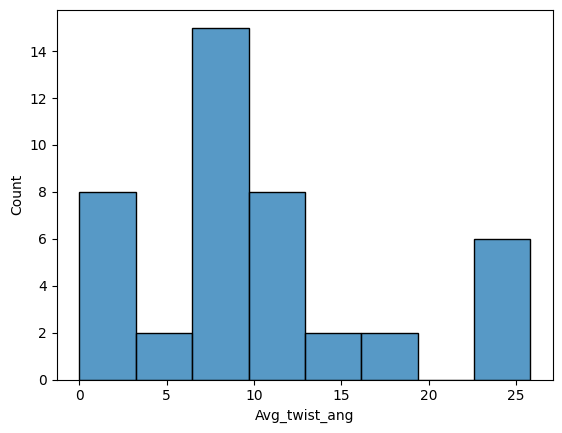

In [8]:
# @title Explore target value ('Avg_twist_ang') distribution

sns.histplot(data=df,x=df['Avg_twist_ang'])


In [9]:
# @title Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
# @title Data pre-processing
X_i, Y_org, X_org, Y_true = initialize_tensors(df)
X_i = X_i.to(device)
Y_org = Y_org.to(device)
X_org = X_org.to(device)
Y_true = Y_true.to(device)
bounds = torch.tensor([[500, 1.0, 1.0], [3500, 1.05, 1.05]],
                      dtype=torch.float64).to(device)
X_init, Y_init = initialize_samples(X_i, Y_org, num_samples=20)


In [11]:
# @title Run BO_AL
set_random_seed(42)
desired_value = 8.5

# Run Bayesian Optimization with the original format of data
results_df = bayesian_optimization(n_iterations=50, X_sample=X_init,\
                                       Y_sample=Y_init, X_i=X_i, Y_org=Y_org,\
                                       bounds=bounds, desired_target=desired_value)
results_df.to_csv('optimization_results.csv', index=False)

best_idx = torch.argmin(torch.abs(Y_init - torch.tensor(desired_value,
                                                            dtype=torch.float64)))
print("Optimization finished.")
print(f"Best location: {X_init[best_idx].cpu().numpy()}")
print(f"Best value: {Y_init[best_idx].cpu().numpy()}")

Acquisition Function: qExpectedImprovement
Kernel: MaternKernel


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6052], dtype=torch.float64), mean = tensor([10.1088], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 1: Candidates = tensor([[1.5221e+03, 1.0118e+00, 1.0460e+00],
        [2.7427e+03, 1.0104e+00, 1.0074e+00],
        [2.0791e+03, 1.0338e+00, 1.0305e+00],
        [9.2793e+02, 1.0239e+00, 1.0328e+00],
        [2.4576e+03, 1.0112e+00, 1.0158e+00]], dtype=torch.float64),             Y_next = [10.19374569 10.19374569 10.19374569 10.19374569 10.19374569], MSE = 109.36895821749152, Uncertainty = 43.84975360754782



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([6.7669], dtype=torch.float64), mean = tensor([10.1258], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 2: Candidates = tensor([[9.4428e+02, 1.0497e+00, 1.0121e+00],
        [2.9035e+03, 1.0359e+00, 1.0267e+00],
        [1.4719e+03, 1.0151e+00, 1.0396e+00],
        [1.6530e+03, 1.0184e+00, 1.0253e+00],
        [1.5597e+03, 1.0163e+00, 1.0333e+00]], dtype=torch.float64),             Y_next = [10.20528824 10.20528824 10.20528824 10.20528824 10.20528824], MSE = 98.01344862550299, Uncertainty = 36.98144021849419



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([6.1560], dtype=torch.float64), mean = tensor([10.1390], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 3: Candidates = tensor([[2.8916e+03, 1.0366e+00, 1.0331e+00],
        [2.2299e+03, 1.0137e+00, 1.0154e+00],
        [2.2652e+03, 1.0273e+00, 1.0347e+00],
        [1.3212e+03, 1.0365e+00, 1.0236e+00],
        [1.6191e+03, 1.0315e+00, 1.0403e+00]], dtype=torch.float64),             Y_next = [10.21478271 10.21478271 10.21478271 10.21478271 10.21478271], MSE = 91.73196199119943, Uncertainty = 31.755492632091382



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([5.6855], dtype=torch.float64), mean = tensor([10.1498], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 4: Candidates = tensor([[2.1140e+03, 1.0070e+00, 1.0282e+00],
        [3.4017e+03, 1.0438e+00, 1.0423e+00],
        [1.1417e+03, 1.0400e+00, 1.0127e+00],
        [6.8590e+02, 1.0072e+00, 1.0421e+00],
        [2.3965e+03, 1.0012e+00, 1.0413e+00]], dtype=torch.float64),             Y_next = [10.22260031 10.22260031 10.22260031 10.22260031 10.22260031], MSE = 83.1231341783335, Uncertainty = 27.681056823041445



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([5.3086], dtype=torch.float64), mean = tensor([10.1589], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 5: Candidates = tensor([[9.3894e+02, 1.0398e+00, 1.0198e+00],
        [1.9608e+03, 1.0478e+00, 1.0339e+00],
        [1.2936e+03, 1.0428e+00, 1.0297e+00],
        [1.7208e+03, 1.0342e+00, 1.0434e+00],
        [6.5152e+02, 1.0282e+00, 1.0180e+00]], dtype=torch.float64),             Y_next = [10.22947885 10.22947885 10.22947885 10.22947885 10.22947885], MSE = 81.6072686024882, Uncertainty = 24.44905815296402



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.9979], dtype=torch.float64), mean = tensor([10.1668], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 6: Candidates = tensor([[1.9288e+03, 1.0039e+00, 1.0391e+00],
        [3.1457e+03, 1.0037e+00, 1.0006e+00],
        [3.2244e+03, 1.0495e+00, 1.0311e+00],
        [2.9424e+03, 1.0459e+00, 1.0159e+00],
        [6.3966e+02, 1.0237e+00, 1.0389e+00]], dtype=torch.float64),             Y_next = [10.2354061 10.2354061 10.2354061 10.2354061 10.2354061], MSE = 73.44668216105813, Uncertainty = 21.83103514715569



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.7361], dtype=torch.float64), mean = tensor([10.1736], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 7: Candidates = tensor([[2.1981e+03, 1.0048e+00, 1.0302e+00],
        [2.9143e+03, 1.0472e+00, 1.0277e+00],
        [2.8063e+03, 1.0407e+00, 1.0097e+00],
        [2.4945e+03, 1.0067e+00, 1.0208e+00],
        [1.7699e+03, 1.0499e+00, 1.0085e+00]], dtype=torch.float64),             Y_next = [10.24071196 10.24071196 10.24071196 10.24071196 10.24071196], MSE = 66.76980394954674, Uncertainty = 19.674645926365816



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.5116], dtype=torch.float64), mean = tensor([10.1797], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 8: Candidates = tensor([[5.0062e+02, 1.0129e+00, 1.0373e+00],
        [2.0084e+03, 1.0435e+00, 1.0318e+00],
        [8.1778e+02, 1.0012e+00, 1.0088e+00],
        [7.5114e+02, 1.0020e+00, 1.0190e+00],
        [3.2056e+03, 1.0161e+00, 1.0055e+00]], dtype=torch.float64),             Y_next = [10.24535283 10.24535283 10.24535283 10.24535283 10.24535283], MSE = 61.20571760291829, Uncertainty = 17.872682956420178



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.3162], dtype=torch.float64), mean = tensor([10.1852], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 9: Candidates = tensor([[2.9049e+03, 1.0334e+00, 1.0442e+00],
        [5.2285e+02, 1.0041e+00, 1.0111e+00],
        [2.1215e+03, 1.0358e+00, 1.0160e+00],
        [1.9823e+03, 1.0491e+00, 1.0147e+00],
        [2.5242e+03, 1.0186e+00, 1.0096e+00]], dtype=torch.float64),             Y_next = [10.24951203 10.24951203 10.24951203 10.24951203 10.24951203], MSE = 56.49763125464643, Uncertainty = 16.3460271789365



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.1442], dtype=torch.float64), mean = tensor([10.1901], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 10: Candidates = tensor([[3.4839e+03, 1.0336e+00, 1.0463e+00],
        [2.3622e+03, 1.0183e+00, 1.0095e+00],
        [2.1534e+03, 1.0047e+00, 1.0164e+00],
        [9.2923e+02, 1.0076e+00, 1.0486e+00],
        [5.3864e+02, 1.0075e+00, 1.0291e+00]], dtype=torch.float64),             Y_next = [10.2531183 10.2531183 10.2531183 10.2531183 10.2531183], MSE = 52.4621190781109, Uncertainty = 15.03768210296291



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.9913], dtype=torch.float64), mean = tensor([10.1946], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 11: Candidates = tensor([[7.7724e+02, 1.0176e+00, 1.0117e+00],
        [3.4833e+03, 1.0247e+00, 1.0152e+00],
        [1.2946e+03, 1.0170e+00, 1.0097e+00],
        [3.4466e+03, 1.0303e+00, 1.0306e+00],
        [3.3483e+03, 1.0021e+00, 1.0024e+00]], dtype=torch.float64),             Y_next = [10.25628091 10.25628091 10.25628091 10.25628091 10.25628091], MSE = 48.96466836700851, Uncertainty = 13.905781226007427



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.8541], dtype=torch.float64), mean = tensor([10.1988], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 12: Candidates = tensor([[2.7082e+03, 1.0023e+00, 1.0194e+00],
        [2.3870e+03, 1.0378e+00, 1.0418e+00],
        [1.4044e+03, 1.0264e+00, 1.0344e+00],
        [3.1520e+03, 1.0199e+00, 1.0076e+00],
        [1.5124e+03, 1.0304e+00, 1.0406e+00]], dtype=torch.float64),             Y_next = [10.25919934 10.25919934 10.25919934 10.25919934 10.25919934], MSE = 45.90439420409261, Uncertainty = 12.916924637191576



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.7302], dtype=torch.float64), mean = tensor([10.2025], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 13: Candidates = tensor([[2.9078e+03, 1.0237e+00, 1.0238e+00],
        [2.2538e+03, 1.0034e+00, 1.0322e+00],
        [2.7811e+03, 1.0452e+00, 1.0056e+00],
        [1.3703e+03, 1.0084e+00, 1.0147e+00],
        [3.3938e+03, 1.0112e+00, 1.0032e+00]], dtype=torch.float64),             Y_next = [10.26199558 10.26199558 10.26199558 10.26199558 10.26199558], MSE = 43.204149164113446, Uncertainty = 12.045842228237595



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.6175], dtype=torch.float64), mean = tensor([10.2060], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 14: Candidates = tensor([[1.6206e+03, 1.0189e+00, 1.0358e+00],
        [2.4802e+03, 1.0401e+00, 1.0353e+00],
        [6.6899e+02, 1.0281e+00, 1.0025e+00],
        [5.8142e+02, 1.0186e+00, 1.0244e+00],
        [3.3919e+03, 1.0273e+00, 1.0403e+00]], dtype=torch.float64),             Y_next = [10.26432553 10.26432553 10.26432553 10.26432553 10.26432553], MSE = 40.80392876080972, Uncertainty = 11.2741582287357



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.5144], dtype=torch.float64), mean = tensor([10.2093], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 15: Candidates = tensor([[2.8631e+03, 1.0102e+00, 1.0380e+00],
        [8.7153e+02, 1.0413e+00, 1.0489e+00],
        [2.2225e+03, 1.0120e+00, 1.0423e+00],
        [6.5881e+02, 1.0093e+00, 1.0467e+00],
        [8.6221e+02, 1.0436e+00, 1.0064e+00]], dtype=torch.float64),             Y_next = [10.26640815 10.26640815 10.26640815 10.26640815 10.26640815], MSE = 38.65636129952804, Uncertainty = 10.585351016085344



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.4197], dtype=torch.float64), mean = tensor([10.2123], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 16: Candidates = tensor([[2.8140e+03, 1.0480e+00, 1.0430e+00],
        [8.2336e+02, 1.0014e+00, 1.0357e+00],
        [8.1595e+02, 1.0158e+00, 1.0173e+00],
        [1.3866e+03, 1.0093e+00, 1.0156e+00],
        [3.3021e+03, 1.0459e+00, 1.0314e+00]], dtype=torch.float64),             Y_next = [10.26846123 10.26846123 10.26846123 10.26846123 10.26846123], MSE = 36.72354940100261, Uncertainty = 9.966884374009128



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3322], dtype=torch.float64), mean = tensor([10.2151], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 17: Candidates = tensor([[3.0936e+03, 1.0448e+00, 1.0175e+00],
        [2.8762e+03, 1.0343e+00, 1.0070e+00],
        [1.0394e+03, 1.0012e+00, 1.0021e+00],
        [2.1663e+03, 1.0182e+00, 1.0074e+00],
        [2.6522e+03, 1.0193e+00, 1.0128e+00]], dtype=torch.float64),             Y_next = [10.27030042 10.27030042 10.27030042 10.27030042 10.27030042], MSE = 34.97481378803161, Uncertainty = 9.409370208907838



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.2512], dtype=torch.float64), mean = tensor([10.2177], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 18: Candidates = tensor([[2.2189e+03, 1.0443e+00, 1.0329e+00],
        [1.6226e+03, 1.0369e+00, 1.0279e+00],
        [6.5044e+02, 1.0280e+00, 1.0280e+00],
        [1.8791e+03, 1.0101e+00, 1.0343e+00],
        [5.0000e+02, 1.0000e+00, 1.0172e+00]], dtype=torch.float64),             Y_next = [10.62817338 10.27188765 10.27188765 10.27188765 10.27188765], MSE = 33.38627130911433, Uncertainty = 8.900887394461165



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1760], dtype=torch.float64), mean = tensor([10.2234], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 19: Candidates = tensor([[1.1007e+03, 1.0176e+00, 1.0245e+00],
        [6.9166e+02, 1.0351e+00, 1.0357e+00],
        [2.5133e+03, 1.0082e+00, 1.0302e+00],
        [1.5734e+03, 1.0084e+00, 1.0020e+00],
        [2.3072e+03, 1.0467e+00, 1.0116e+00]], dtype=torch.float64),             Y_next = [10.27343828 10.27343828 10.27343828 10.27343828 10.27343828], MSE = 31.934697321518275, Uncertainty = 8.433939780426567



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1056], dtype=torch.float64), mean = tensor([10.2256], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 20: Candidates = tensor([[3.1860e+03, 1.0055e+00, 1.0426e+00],
        [1.1493e+03, 1.0205e+00, 1.0265e+00],
        [1.0449e+03, 1.0201e+00, 1.0332e+00],
        [2.7390e+03, 1.0122e+00, 1.0202e+00],
        [3.0570e+03, 1.0340e+00, 1.0274e+00]], dtype=torch.float64),             Y_next = [10.27474523 10.27474523 10.27474523 10.27474523 10.27474523], MSE = 30.60408732893651, Uncertainty = 8.013213007178175



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.0396], dtype=torch.float64), mean = tensor([10.2276], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 21: Candidates = tensor([[9.6582e+02, 1.0463e+00, 1.0423e+00],
        [1.8151e+03, 1.0126e+00, 1.0206e+00],
        [9.5958e+02, 1.0409e+00, 1.0296e+00],
        [1.1168e+03, 1.0438e+00, 1.0156e+00],
        [1.5693e+03, 1.0191e+00, 1.0426e+00]], dtype=torch.float64),             Y_next = [10.27591838 10.27591838 10.27591838 10.27591838 10.27591838], MSE = 29.379925675382875, Uncertainty = 7.627078404598327



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9777], dtype=torch.float64), mean = tensor([10.2296], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 22: Candidates = tensor([[7.6192e+02, 1.0409e+00, 1.0173e+00],
        [1.4566e+03, 1.0134e+00, 1.0328e+00],
        [1.0196e+03, 1.0401e+00, 1.0115e+00],
        [3.4077e+03, 1.0108e+00, 1.0213e+00],
        [1.3186e+03, 1.0206e+00, 1.0474e+00]], dtype=torch.float64),             Y_next = [10.27698418 10.27698418 10.27698418 10.27698418 10.27698418], MSE = 28.25087848668, Uncertainty = 7.271762200856518



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.9195], dtype=torch.float64), mean = tensor([10.2314], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 23: Candidates = tensor([[3.4294e+03, 1.0158e+00, 1.0455e+00],
        [1.2973e+03, 1.0107e+00, 1.0432e+00],
        [2.7834e+03, 1.0449e+00, 1.0272e+00],
        [1.1537e+03, 1.0357e+00, 1.0236e+00],
        [9.1589e+02, 1.0170e+00, 1.0191e+00]], dtype=torch.float64),             Y_next = [10.27797096 10.27797096 10.27797096 10.27797096 10.27797096], MSE = 27.204550780583233, Uncertainty = 6.9433056044181365



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.8645], dtype=torch.float64), mean = tensor([10.2331], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 24: Candidates = tensor([[1.1729e+03, 1.0097e+00, 1.0350e+00],
        [7.5950e+02, 1.0125e+00, 1.0476e+00],
        [1.8785e+03, 1.0397e+00, 1.0032e+00],
        [1.8230e+03, 1.0397e+00, 1.0197e+00],
        [3.3731e+03, 1.0430e+00, 1.0135e+00]], dtype=torch.float64),             Y_next = [10.27888395 10.27888395 10.27888395 10.27888395 10.27888395], MSE = 26.232960561446884, Uncertainty = 6.639487859154603



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.8125], dtype=torch.float64), mean = tensor([10.2348], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 25: Candidates = tensor([[2.0975e+03, 1.0257e+00, 1.0193e+00],
        [3.2074e+03, 1.0152e+00, 1.0387e+00],
        [1.0320e+03, 1.0205e+00, 1.0181e+00],
        [2.1190e+03, 1.0135e+00, 1.0225e+00],
        [1.7343e+03, 1.0328e+00, 1.0021e+00]], dtype=torch.float64),             Y_next = [10.2797182 10.2797182 10.2797182 10.2797182 10.2797182], MSE = 25.32837642531983, Uncertainty = 6.35735453796842



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.7633], dtype=torch.float64), mean = tensor([10.2363], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 26: Candidates = tensor([[2.5049e+03, 1.0389e+00, 1.0209e+00],
        [2.5086e+03, 1.0297e+00, 1.0253e+00],
        [6.6313e+02, 1.0312e+00, 1.0480e+00],
        [6.5525e+02, 1.0004e+00, 1.0320e+00],
        [1.8427e+03, 1.0314e+00, 1.0461e+00]], dtype=torch.float64),             Y_next = [10.28048573 10.28048573 10.28048573 10.28048573 10.28048573], MSE = 24.484097791832927, Uncertainty = 6.094791345335915



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.7165], dtype=torch.float64), mean = tensor([10.2378], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 27: Candidates = tensor([[2.1835e+03, 1.0067e+00, 1.0492e+00],
        [2.5830e+03, 1.0344e+00, 1.0155e+00],
        [3.0426e+03, 1.0070e+00, 1.0344e+00],
        [2.0257e+03, 1.0076e+00, 1.0231e+00],
        [1.8382e+03, 1.0062e+00, 1.0362e+00]], dtype=torch.float64),             Y_next = [10.28125095 10.28125095 10.28125095 10.28125095 10.28125095], MSE = 23.694288676823046, Uncertainty = 5.849298798912469



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.6721], dtype=torch.float64), mean = tensor([10.2392], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 28: Candidates = tensor([[1.0035e+03, 1.0499e+00, 1.0487e+00],
        [1.3527e+03, 1.0457e+00, 1.0081e+00],
        [2.0672e+03, 1.0102e+00, 1.0244e+00],
        [2.7906e+03, 1.0049e+00, 1.0222e+00],
        [2.2250e+03, 1.0445e+00, 1.0088e+00]], dtype=torch.float64),             Y_next = [10.28181226 10.28181226 10.28181226 10.28181226 10.28181226], MSE = 22.953842539528434, Uncertainty = 5.6204378842747



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.6297], dtype=torch.float64), mean = tensor([10.2405], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 29: Candidates = tensor([[2.1772e+03, 1.0131e+00, 1.0164e+00],
        [5.1757e+02, 1.0202e+00, 1.0108e+00],
        [1.6943e+03, 1.0484e+00, 1.0414e+00],
        [1.7190e+03, 1.0147e+00, 1.0080e+00],
        [2.0070e+03, 1.0230e+00, 1.0483e+00]], dtype=torch.float64),             Y_next = [10.28239185 10.28239185 10.28239185 10.28239185 10.28239185], MSE = 22.258271863864177, Uncertainty = 5.406027658963244



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5894], dtype=torch.float64), mean = tensor([10.2418], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 30: Candidates = tensor([[2.6362e+03, 1.0082e+00, 1.0114e+00],
        [3.1178e+03, 1.0223e+00, 1.0400e+00],
        [9.0413e+02, 1.0275e+00, 1.0306e+00],
        [9.0219e+02, 1.0211e+00, 1.0002e+00],
        [3.0744e+03, 1.0429e+00, 1.0448e+00]], dtype=torch.float64),             Y_next = [10.28297406 10.28297406 10.28297406 10.28297406 10.28297406], MSE = 21.603617068958915, Uncertainty = 5.204408944658104



/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5508], dtype=torch.float64), mean = tensor([10.2430], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise

No unique candidates found. Skipping update for this iteration.
Iteration 31: Candidates = tensor([[2.5545e+03, 1.0087e+00, 1.0346e+00],
        [1.8996e+03, 1.0244e+00, 1.0459e+00],
        [1.7737e+03, 1.0090e+00, 1.0315e+00],
        [2.0126e+03, 1.0123e+00, 1.0087e+00],
        [2.3929e+03, 1.0325e+00, 1.0075e+00]], dtype=torch.float64),             Y_next = [10.28344939 10.28344939 10.28344939 10.28344939 10.28344939], MSE = 20.986371072794867, Uncertainty = 5.01519626922817



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.5139], dtype=torch.float64), mean = tensor([10.2441], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 32: Candidates = tensor([[2.7752e+03, 1.0057e+00, 1.0250e+00],
        [3.2268e+03, 1.0242e+00, 1.0387e+00],
        [1.5308e+03, 1.0287e+00, 1.0017e+00],
        [2.9154e+03, 1.0397e+00, 1.0254e+00],
        [3.1103e+03, 1.0175e+00, 1.0165e+00]], dtype=torch.float64),             Y_next = [10.28389545 10.28389545 10.28389545 10.28389545 10.28389545], MSE = 20.40341648554758, Uncertainty = 4.836865188781348



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.4785], dtype=torch.float64), mean = tensor([10.2453], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 33: Candidates = tensor([[2.6908e+03, 1.0325e+00, 1.0005e+00],
        [5.3539e+02, 1.0142e+00, 1.0426e+00],
        [1.4996e+03, 1.0170e+00, 1.0253e+00],
        [3.1132e+03, 1.0255e+00, 1.0297e+00],
        [2.9765e+03, 1.0299e+00, 1.0394e+00]], dtype=torch.float64),             Y_next = [10.28434634 10.28434634 10.28434634 10.28434634 10.28434634], MSE = 19.851972942179543, Uncertainty = 4.6685609226851374



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.4446], dtype=torch.float64), mean = tensor([10.2463], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 34: Candidates = tensor([[3.3801e+03, 1.0043e+00, 1.0175e+00],
        [1.1231e+03, 1.0366e+00, 1.0443e+00],
        [5.1969e+02, 1.0269e+00, 1.0268e+00],
        [6.9829e+02, 1.0104e+00, 1.0370e+00],
        [1.8131e+03, 1.0150e+00, 1.0130e+00]], dtype=torch.float64),             Y_next = [10.2846967 10.2846967 10.2846967 10.2846967 10.2846967], MSE = 19.329552716711785, Uncertainty = 4.509749308896433



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.4121], dtype=torch.float64), mean = tensor([10.2473], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 35: Candidates = tensor([[1.4691e+03, 1.0144e+00, 1.0329e+00],
        [3.2190e+03, 1.0442e+00, 1.0043e+00],
        [2.2035e+03, 1.0015e+00, 1.0299e+00],
        [6.2388e+02, 1.0232e+00, 1.0008e+00],
        [2.3636e+03, 1.0462e+00, 1.0318e+00]], dtype=torch.float64),             Y_next = [10.28504552 10.28504552 10.28504552 10.28504552 10.28504552], MSE = 18.83392325201703, Uncertainty = 4.359455781846084



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.3808], dtype=torch.float64), mean = tensor([10.2483], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 36: Candidates = tensor([[2.7263e+03, 1.0336e+00, 1.0244e+00],
        [1.8092e+03, 1.0092e+00, 1.0175e+00],
        [5.8810e+02, 1.0400e+00, 1.0308e+00],
        [3.2261e+03, 1.0138e+00, 1.0059e+00],
        [1.8261e+03, 1.0195e+00, 1.0147e+00]], dtype=torch.float64),             Y_next = [10.28533415 10.28533415 10.28533415 10.28533415 10.28533415], MSE = 18.363075244700436, Uncertainty = 4.217073648759423



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.3507], dtype=torch.float64), mean = tensor([10.2492], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 37: Candidates = tensor([[1.3489e+03, 1.0436e+00, 1.0318e+00],
        [2.0877e+03, 1.0391e+00, 1.0051e+00],
        [1.7073e+03, 1.0161e+00, 1.0385e+00],
        [1.0490e+03, 1.0204e+00, 1.0023e+00],
        [3.2373e+03, 1.0003e+00, 1.0187e+00]], dtype=torch.float64),             Y_next = [10.28561239 10.28561239 10.28561239 10.28561239 10.28561239], MSE = 17.91519541946083, Uncertainty = 4.082078238523952



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.3217], dtype=torch.float64), mean = tensor([10.2501], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 38: Candidates = tensor([[9.8909e+02, 1.0147e+00, 1.0229e+00],
        [5.0000e+02, 1.0000e+00, 1.0196e+00],
        [1.2276e+03, 1.0055e+00, 1.0009e+00],
        [1.6427e+03, 1.0316e+00, 1.0257e+00],
        [1.6441e+03, 1.0322e+00, 1.0437e+00]], dtype=torch.float64),             Y_next = [10.9319528  10.28586364 10.28586364 10.28586364 10.28586364], MSE = 17.490640297380747, Uncertainty = 3.951428306296476



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2943], dtype=torch.float64), mean = tensor([10.2540], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 39: Candidates = tensor([[2.5488e+03, 1.0110e+00, 1.0254e+00],
        [2.7819e+03, 1.0444e+00, 1.0115e+00],
        [1.1190e+03, 1.0204e+00, 1.0320e+00],
        [1.1351e+03, 1.0260e+00, 1.0337e+00],
        [3.1896e+03, 1.0257e+00, 1.0366e+00]], dtype=torch.float64),             Y_next = [10.28610755 10.28610755 10.28610755 10.28610755 10.28610755], MSE = 17.083881258963746, Uncertainty = 3.824230381654867



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2673], dtype=torch.float64), mean = tensor([10.2548], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 40: Candidates = tensor([[6.2723e+02, 1.0230e+00, 1.0129e+00],
        [2.7651e+03, 1.0175e+00, 1.0338e+00],
        [2.2912e+03, 1.0087e+00, 1.0433e+00],
        [2.8931e+03, 1.0361e+00, 1.0302e+00],
        [1.8856e+03, 1.0231e+00, 1.0098e+00]], dtype=torch.float64),             Y_next = [10.28628438 10.28628438 10.28628438 10.28628438 10.28628438], MSE = 16.6956112594883, Uncertainty = 3.7085528781829553



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2413], dtype=torch.float64), mean = tensor([10.2555], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 41: Candidates = tensor([[2.4979e+03, 1.0276e+00, 1.0279e+00],
        [2.0168e+03, 1.0127e+00, 1.0417e+00],
        [1.2497e+03, 1.0445e+00, 1.0231e+00],
        [1.6456e+03, 1.0485e+00, 1.0167e+00],
        [2.7055e+03, 1.0263e+00, 1.0066e+00]], dtype=torch.float64),             Y_next = [10.28644061 10.28644061 10.28644061 10.28644061 10.28644061], MSE = 16.32459769836468, Uncertainty = 3.5984094753721703



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2161], dtype=torch.float64), mean = tensor([10.2562], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 42: Candidates = tensor([[1.3665e+03, 1.0191e+00, 1.0396e+00],
        [6.1361e+02, 1.0334e+00, 1.0166e+00],
        [7.9243e+02, 1.0446e+00, 1.0114e+00],
        [2.3431e+03, 1.0102e+00, 1.0024e+00],
        [3.1661e+03, 1.0476e+00, 1.0426e+00]], dtype=torch.float64),             Y_next = [10.28657624 10.28657624 10.28657624 10.28657624 10.28657624], MSE = 15.971526071010308, Uncertainty = 3.493402613035614



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1918], dtype=torch.float64), mean = tensor([10.2568], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 43: Candidates = tensor([[2.6126e+03, 1.0414e+00, 1.0341e+00],
        [2.1297e+03, 1.0038e+00, 1.0113e+00],
        [2.0551e+03, 1.0227e+00, 1.0202e+00],
        [6.7307e+02, 1.0407e+00, 1.0443e+00],
        [1.5003e+03, 1.0326e+00, 1.0207e+00]], dtype=torch.float64),             Y_next = [10.28669051 10.28669051 10.28669051 10.28669051 10.28669167], MSE = 15.631706378998143, Uncertainty = 3.393271881476071



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1683], dtype=torch.float64), mean = tensor([10.2575], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 44: Candidates = tensor([[1.3438e+03, 1.0090e+00, 1.0135e+00],
        [3.0076e+03, 1.0258e+00, 1.0498e+00],
        [2.6817e+03, 1.0287e+00, 1.0433e+00],
        [3.2024e+03, 1.0404e+00, 1.0084e+00],
        [2.4598e+03, 1.0375e+00, 1.0199e+00]], dtype=torch.float64),             Y_next = [10.28678681 10.28678681 10.28678681 10.28678681 10.28678681], MSE = 15.306045837306845, Uncertainty = 3.2976141188200168



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1455], dtype=torch.float64), mean = tensor([10.2581], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 45: Candidates = tensor([[1.5281e+03, 1.0006e+00, 1.0058e+00],
        [2.9396e+03, 1.0480e+00, 1.0152e+00],
        [8.7233e+02, 1.0134e+00, 1.0160e+00],
        [2.8728e+03, 1.0421e+00, 1.0476e+00],
        [2.9926e+03, 1.0497e+00, 1.0268e+00]], dtype=torch.float64),             Y_next = [10.28686866 10.28686866 10.28686866 10.28686866 10.28686866], MSE = 14.993677560588653, Uncertainty = 3.2061440721154932



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1234], dtype=torch.float64), mean = tensor([10.2587], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 46: Candidates = tensor([[2.2013e+03, 1.0075e+00, 1.0147e+00],
        [1.5446e+03, 1.0300e+00, 1.0321e+00],
        [1.8720e+03, 1.0442e+00, 1.0488e+00],
        [2.2238e+03, 1.0137e+00, 1.0393e+00],
        [2.9245e+03, 1.0185e+00, 1.0358e+00]], dtype=torch.float64),             Y_next = [10.28693689 10.28693689 10.28693689 10.28693689 10.28693689], MSE = 14.69380401337293, Uncertainty = 3.1185595695518984



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1020], dtype=torch.float64), mean = tensor([10.2592], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 47: Candidates = tensor([[2.9610e+03, 1.0207e+00, 1.0328e+00],
        [7.8498e+02, 1.0361e+00, 1.0415e+00],
        [3.1960e+03, 1.0447e+00, 1.0256e+00],
        [7.0695e+02, 1.0406e+00, 1.0008e+00],
        [2.5890e+03, 1.0296e+00, 1.0145e+00]], dtype=torch.float64),             Y_next = [10.28698499 10.28698499 10.28698499 10.28698499 10.28698499], MSE = 14.405690211834864, Uncertainty = 3.0348946520159457



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0812], dtype=torch.float64), mean = tensor([10.2598], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 48: Candidates = tensor([[1.6236e+03, 1.0223e+00, 1.0467e+00],
        [2.1240e+03, 1.0432e+00, 1.0148e+00],
        [2.3497e+03, 1.0127e+00, 1.0169e+00],
        [2.0712e+03, 1.0402e+00, 1.0415e+00],
        [1.2385e+03, 1.0295e+00, 1.0483e+00]], dtype=torch.float64),             Y_next = [10.28692792 10.28692792 10.28692792 10.28692792 10.28692792], MSE = 14.12865770856255, Uncertainty = 2.954903980282358



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0610], dtype=torch.float64), mean = tensor([10.2603], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 49: Candidates = tensor([[3.1930e+03, 1.0079e+00, 1.0295e+00],
        [2.4903e+03, 1.0266e+00, 1.0096e+00],
        [2.0667e+03, 1.0253e+00, 1.0470e+00],
        [2.7188e+03, 1.0315e+00, 1.0387e+00],
        [2.8275e+03, 1.0450e+00, 1.0023e+00]], dtype=torch.float64),             Y_next = [10.28706299 10.28706299 10.28706299 10.28706299 10.28706299], MSE = 13.862079262379659, Uncertainty = 2.8782775997295937



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0414], dtype=torch.float64), mean = tensor([10.2608], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
Iteration 50: Candidates = tensor([[1.4016e+03, 1.0331e+00, 1.0138e+00],
        [7.4299e+02, 1.0017e+00, 1.0389e+00],
        [1.3948e+03, 1.0317e+00, 1.0353e+00],
        [3.3978e+03, 1.0149e+00, 1.0280e+00],
        [1.9478e+03, 1.0078e+00, 1.0291e+00]], dtype=torch.float64),             Y_next = [10.28708118 10.28708118 10.28708118 10.28708118 10.28708118], MSE = 13.605374091510143, Uncertainty = 2.8043598108170835



<ipython-input-5-3421bb267536>:204: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Optimization finished.
Best location: [2.500e+03 1.035e+00 1.035e+00]
Best value: [8.43504433]
